# Show a rendom agent playing pong

## Setting up a custom Pong Environment

Skipping initial frames to start without initial idle frames and Cutting episodes after 200 steps

In [2]:
import gymnasium as gym
from gymnasium.spaces import Discrete, Box
import numpy as np

class CustomPongEnv(gym.Env):
    def __init__(self, env_config=None):
        super().__init__()
        self.default_env = gym.make("ALE/Pong-v5")


        self.observation_space = Box(low=0, high=255, shape=(84, 84, 3), dtype=np.uint8)
        self.action_space = self.default_env.action_space  # Example: move up or down
        self.max_episode_steps = 200  # Set a max length for each episode to around 20 seconds of playtime
        self.current_step = 0
        self.skip_initial_steps = 40 

    def reset(self, **kwargs):
        self.current_step = 0
        obs, info = self.default_env.reset()
            # Skip the first `skip_initial_steps` by taking no-op actions
        for _ in range(self.skip_initial_steps):
            obs, _, terminated, truncated, _ = self.default_env.step(0)  # Assuming action `0` is no-op
            if terminated or truncated:  # If the episode ends during skipping, reset again
                obs, _ = self.default_env.reset(**kwargs)

        return obs, info

    def step(self, action):
        self.current_step += 1
        
        obs, reward, terminated, truncated, info = self.default_env.step(action)
        done = terminated or truncated or (self.current_step >= self.max_episode_steps)
        return obs, reward, done, truncated, info


## show a random agent playing pong
evaluate the episodes make sense and the agent acts while not getting stuck

(210, 160, 3)


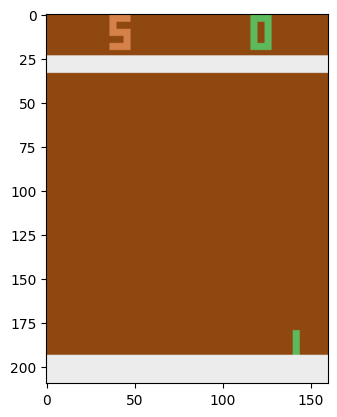

episode terminated


In [3]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
import ale_py
import gymnasium as gym
import shimmy
from gymnasium.wrappers import AtariPreprocessing

import PIL.Image
env_name = "ALE/Pong-v5"

print(gym.pprint_registry())
env = CustomPongEnv()
env.reset()

for _ in range(200):
    action = env.action_space.sample()
    observation, reward, terminated, truncated, info = env.step(action)

    clear_output(wait=True)
    print(observation.shape)
    plt.imshow(observation)
    plt.show()

    if terminated:
        observation, info = env.reset()
        print("episode terminated")
env.close()

## Implement a wrapper for the observation
* convert to grayscale
* normalize observation
* convert data shape
* removing top and bottom which is not part of the playing field
* down sample the image for performance
* adding padding around the image 

In [4]:
from ray.rllib.models.preprocessors import Preprocessor
from ray.rllib.models import ModelCatalog
import gymnasium as gym
import numpy as np

class MyWrapper(gym.ObservationWrapper):
    dim = (210,160)
    padding = 2

    def __init__(self, env):
        super().__init__(env)
        # Adjust the observation space to reflect the grayscale image shape
        obs_shape = self.observation_space.shape
        print(type(env.observation_space))
        env.observation_space
        self.observation_space = gym.spaces.Box(
            low=0.0, high=1.0,
            shape=(84, 84, 1),
            dtype=np.float32
        )
        print(type(self.observation_space))

    def observation(self, incomming_observation):
        observation = np.copy(incomming_observation)
        # Convert the observation to grayscale
        observation = np.dot(observation[...,:3], [0.333, 0.333, 0.333])
        # Normalize the grayscale image to the range [0, 1]
        observation = observation / 255.0
        observation = observation[..., np.newaxis]
        # Remove all but playingfield
        observation = observation[34:-16]
        # Reduce size of the image for faster inference
        observation = observation[::2, ::2]
        observation = np.pad(observation, ((self.padding, self.padding), (self.padding, self.padding), (0, 0)),mode='constant', constant_values=0) 
        return observation
# Register the preprocessor
#ModelCatalog.register_custom_preprocessor("custom_obs_preprocessor", CustomObservationPreprocessor)


## Helper function for debugging purposes
visualization of a episode in mp4 video format

In [13]:
import cv2
import numpy as np
import torch


def save_observations_as_video(observations, output_path, fps=30):
    """
    Saves a sequence of observations (frames) as a video file, with numerical array overlays.

    Args:
        observations (torch.Tensor or list of torch.Tensor): Tensor of frames with shape [batch_size, H, W, C]
                                                             or a list of tensors each shaped [1, H, W, 1].
        output_path (str): Path to save the output video file.
        fps (int): Frames per second for the output video.
    """
    # Handle PyTorch tensor input
    if isinstance(observations, torch.Tensor):
        # Ensure observations have shape [batch_size, H, W, C]
        if len(observations.shape) == 4:  # [batch_size, H, W, C]
            observations = [obs.squeeze().cpu().numpy() for obs in observations]
        else:
            raise ValueError("Expected observations tensor with shape [batch_size, H, W, C].")

    # Ensure observations is not empty
    if observations is None or len(observations) == 0:
        print("No observations to save.")
        return

    # Process each observation
    processed_frames = []
    for obs in observations:
        frame_rgb = None
        # If observation is grayscale, convert to RGB
        if len(obs.shape) == 2:  # Shape: [H, W]
            frame_rgb = cv2.cvtColor((obs * 255).astype(np.uint8), cv2.COLOR_GRAY2BGR)
        elif len(obs.shape) == 3 and obs.shape[-1] == 1:  # Shape: [H, W, 1]
            frame_rgb = cv2.cvtColor((obs.squeeze(-1) * 255).astype(np.uint8), cv2.COLOR_GRAY2BGR)
        elif len(obs.shape) == 3 and obs.shape[-1] == 3:  # Shape: [H, W, 3]
            frame_rgb = (obs * 255).astype(np.uint8)
        else:
            raise ValueError(f"Unexpected observation shape: {obs.shape}")

        # Overlay numerical values as text on the frame
        overlay_frame = frame_rgb.copy()
        height, width = frame_rgb.shape[:2]

        processed_frames.append(overlay_frame)

    # Get video dimensions
    height, width, _ = processed_frames[0].shape

    # Define the codec and initialize VideoWriter
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec for .mp4 format
    video_writer = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    for frame in processed_frames:
        video_writer.write(frame)

    video_writer.release()
    print(f"Video saved at {output_path}")

# Custom Distribution for Epsilon greedy implementation

In [14]:
import torch
from ray.rllib.models.distributions import Distribution
from ray.rllib.utils.typing import TensorType

from ray.rllib.models.torch.torch_distributions import (TorchDistribution, TorchDeterministic)

class CustomDistribution(TorchDistribution):
    
    def __init__(
        self,
        logits: torch.Tensor = None,
        probs: torch.Tensor = None,
    ) -> None:
        # We assert this here because to_deterministic makes this assumption.
        assert (probs is None) != (
            logits is None
        ), "Exactly one out of `probs` and `logits` must be set!"

        self.probs = probs
        self.logits = logits
        super().__init__(logits=logits, probs=probs)

        # Build this distribution only if really needed (in `self.rsample()`). It's
        # quite expensive according to cProfile.
        self._one_hot = None
        
        # Epsilon settings
        self.epsilon = 1
        self.final_epsilon = 0.01 # 1 % of actions shall remain random
        self.epsilon_decay = 5e-5  # Adjust decay rate as needed -> 10k Steps before min randomeness is reached

    def sample(self, sample_shape=torch.Size()):
        """
        Apply epsilon-greedy sampling logic.
        """
        # Use torch's Categorical to handle logits or probs
        categorical_dist = self._get_torch_distribution(
            logits=self.logits, probs=self.probs
        )

        self.epsilon = max(
                self.final_epsilon,
                self.epsilon - self.epsilon_decay,
            )
        
        # Get greedy action (exploitation)
        greedy_action = torch.argmax(self.logits if self.logits is not None else self.probs, dim=-1)

        # Get random action (exploration)
        random_action = torch.randint(0, self.logits.shape[-1], greedy_action.shape)

        # Perform epsilon-greedy decision
        exploration_mask = torch.rand(greedy_action.shape) < self.epsilon
        final_action = torch.where(exploration_mask, random_action, greedy_action)

        return final_action

    def _get_torch_distribution(
        self,
        logits: torch.Tensor = None,
        probs: torch.Tensor = None,
    ) -> "torch.distributions.Distribution":
        return torch.distributions.categorical.Categorical(logits=logits, probs=probs)

    def required_input_dim(space: gym.Space, **kwargs) -> int:
        assert isinstance(space, gym.spaces.Discrete)
        return int(space.n)

    def rsample(self, sample_shape=()):
        return self.sample(sample_shape=sample_shape)

    @classmethod
    def from_logits(cls, logits, **kwargs) -> "CustomDistribution":
        return CustomDistribution(logits=logits, **kwargs)

    def to_deterministic(self) -> "TorchDeterministic":
        if self.probs is not None:
            probs_or_logits = self.probs
        else:
            probs_or_logits = self.logits

        return CustomDistribution(loc=torch.argmax(probs_or_logits, dim=-1))


# Creation of a DQN Model
* Implementation of an online model
* Implemenation of a target network with update policy
* Implementation of forward inference
* returning logits for the current and next observation as well as logits for the training network


In [15]:
from ray.rllib.core.rl_module.torch.torch_rl_module import TorchRLModule
from ray.rllib.utils.framework import try_import_torch
from ray.rllib.models.torch.torch_modelv2 import TorchModelV2
from ray.rllib.models.torch.fcnet import FullyConnectedNetwork
from ray.rllib.models.preprocessors import get_preprocessor
from ray.rllib.utils.torch_utils import FLOAT_MIN
from ray.rllib.utils.annotations import override
from ray.rllib.models import ModelCatalog
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torch as torch
from ray.rllib.core.rl_module.rl_module import RLModuleConfig
from typing import Any, Dict

from typing import Any, Dict, Type
from ray.rllib.models.torch.torch_distributions import TorchDistribution

from torch import flatten
import json

torch, nn = try_import_torch()


class CustomAtariRLModule(TorchRLModule):
    def setup(self):
        # Extract observation and action space information from the config
        obs_shape = self.observation_space.shape  # (1, 84, 84)
        num_actions = self.action_space.n        # Number of discrete actions (e.g., 6)
        # Define the convolutional layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)

        # Compute the size of the flattened layer
        flattened_size = 64 * 7 * 7  # Adjusted for (84, 84) input size

        # Define the fully connected layers
        self.fc1 = nn.Linear(flattened_size, 512)
        self.action_head = nn.Linear(512, num_actions)
        
        # Target network
        self.target_conv1 = nn.Conv2d(1, 32, 8, stride=4)
        self.target_conv2 = nn.Conv2d(32, 64, 4, stride=2)
        self.target_conv3 = nn.Conv2d(64, 64, 3, stride=1)
        self.target_fc1 = nn.Linear(64 * 7 * 7, 512)
        self.target_action_head = nn.Linear(512, self.action_space.n)

        # Copy weights from the online network to the target network
        self._update_target_network()

        self.target_update_frequency = 400;
        self.iter = 0;

    def get_exploration_action_dist_cls(self) -> Type[TorchDistribution]:
        return CustomDistribution

    def _forward_train(self, batch: Dict[str, Any], **kwargs) -> Dict[str, Any]:
        # Forward pass through the network
        #print(batch["obs"].size())
        self.iter  += 1

        #update targaet network
        if self.iter % self.target_update_frequency == 0:
            self._update_target_network()
        
        action_logits = None

        #if batch["obs"].shape[0] > 1:
        #    print("batchsize: ", batch["obs"].shape[0])
        #    save_observations_as_video(batch["obs"], "./test_obs_vid.mp4")

        x = batch["obs"].permute(0, 3, 1, 2)
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        #x = flatten(x).reshape(1,64*7*7)
        x = x.reshape(x.size(0), -1) 
        x = torch.relu(self.fc1(x))
        action_logits = self.action_head(x)


        #print("actionLogits: ", action_logits)

        next_q_values = None

        # Compute Q-values for next states using the same logic (or via a target network)
        if 'new_obs' in batch.keys():
            #print("next obs available")
            next_obs = batch["new_obs"].permute(0, 3, 1, 2)  # Handle next states
            next_x = torch.relu(self.conv1(next_obs))
            next_x = torch.relu(self.conv2(next_x))
            next_x = torch.relu(self.conv3(next_x))
            next_x = next_x.reshape(next_x.size(0), -1)
            next_x = torch.relu(self.fc1(next_x))
            next_q_values = self.action_head(next_x)   # Q-values for next observations


            # Compute Q-values for next observations using the target network
            with torch.no_grad():  # Ensure no gradients are computed for the target network
                target_next_x = torch.relu(self.target_conv1(next_obs))
                target_next_x = torch.relu(self.target_conv2(target_next_x))
                target_next_x = torch.relu(self.target_conv3(target_next_x))
                target_next_x = target_next_x.reshape(target_next_x.size(0), -1)
                target_next_x = torch.relu(self.target_fc1(target_next_x))
                qf_target_next_preds = self.target_action_head(target_next_x)
                
                #print("targetActionLogits: ", qf_target_next_preds)
            return {"action_dist_inputs": action_logits, "qf_preds":action_logits, "qf_target_next_preds": qf_target_next_preds, "qf_next_preds":next_q_values} 
        # Return action distribution
        return {"action_dist_inputs": action_logits, "qf_preds":action_logits}

    def _forward_inference(self, batch: Dict[str, Any], **kwargs) -> Dict[str, Any]:
        with torch.no_grad():
            return self._forward_train(batch, explore = False)

    def _forward_exploration(self, batch: Dict[str, Any], **kwargs) -> Dict[str, Any]:
        #with torch.no_grad():
         return self._forward_train(batch)


    def _update_target_network(self):
        for target_param, param in zip(self.target_parameters(), self.parameters()):
            target_param.data.copy_(param.data)
        #print(list(self.conv1.parameters()))

    def target_parameters(self):
    # Return all target network parameters
        return list(self.target_conv1.parameters()) + \
               list(self.target_conv2.parameters()) + \
               list(self.target_conv3.parameters()) + \
               list(self.target_fc1.parameters()) + \
               list(self.target_action_head.parameters())

    def parameters(self):
        # Return all online network parameters
        return list(self.conv1.parameters()) + \
               list(self.conv2.parameters()) + \
               list(self.conv3.parameters()) + \
               list(self.fc1.parameters()) + \
               list(self.action_head.parameters())

# Register the custom RLModule
ModelCatalog.register_custom_model("custom_atari_module", CustomAtariRLModule)


# Setup DQN Agent of Rllib with needed Settings and debug callbacks

In [6]:
import ray
from ray.rllib.algorithms.dqn import DQNConfig
import ale_py
import shimmy
from gymnasium.envs.registration import register
from ray.rllib.core.rl_module.rl_module import RLModuleSpec
from ray.rllib.algorithms.callbacks import DefaultCallbacks
from ray.rllib.policy import Policy
from ray.rllib.policy.sample_batch import SampleBatch

from ray.rllib.env.single_agent_env_runner import SingleAgentEnvRunner



# Wrap the environment
def custom_env_creator(env_config):
    env = CustomPongEnv() #gym.make("ALE/Pong-v5",  **env_config.get("gym_kwargs", {}))
    print(env.observation_space, env.action_space)
    env = MyWrapper(env)
    return env

from ray.rllib.algorithms.callbacks import DefaultCallbacks

class DebugCallback(DefaultCallbacks):
    def on_episode_start(self, *, episode, **kwargs):
        print(f"Episode started.")
    
    def on_episode_end(self, *, episode, **kwargs):
        print(f"Episode ended with length {episode.__len__()}.")
    
    def on_sample_end(self, *, samples, **kwargs):
        print("Sample batch collected:")
    
        # If the samples are in SAEps format (list of episodes):
        if isinstance(samples, list):
            for idx, episode in enumerate(samples):
                save_observations_as_video(episode.get_observations(), "./samles.mp4")
                print(f"  Episode {idx}:")
                print(f"    Length: {episode.__len__()}")  # Total length of the episode
                print(f"    Done: {episode.is_done}")  # Done flag of the episode
                print(f"    Reward: {episode.get_return}")  # Episode reward
                
                # Access observations, rewards, and done flags
                # Assuming `episode` stores these as numpy arrays or lists
                print(f"    Observations (sample size): {len(episode.get_observations())}")  # Show first observation in the episode
                #print(f"    Rewards (sample): {episode.get_rewards[:5]}")  # Show first 5 rewards in the episode
                #print(f"    Done flags (sample): {episode.dones[:5]}")  # Show first 5 done flags in the episode
    
        else:
            print(f"  Unexpected format: {samples}")

        #save_observations_as_video(samples.get_observations(), "./samles.mp4")

    def before_learn_on_batch(self, *, policy:Policy, train_batch:SampleBatch, result, **kwargs):
        print("====== Training Batch Debug ======")
        print(f"Train Batch Size: {train_batch.count}")

        if SampleBatch.SEQ_LENS in train_batch:
            print(f"Sequence Lengths: {train_batch[SampleBatch.SEQ_LENS]}")
        
        print("Sampled Observations:")
        save_observations_as_video(train_batch["obs"], "./train_batch.mp4")
        
        raise Exception("blub")

environment = custom_env_creator({})

# Configure the DQN Algorithm
config:DQNConfig = (
    DQNConfig()
    #.callbacks(DebugCallback)
    .environment(
        env="custom_pong_env",  # Atari Pong environment (gymnasium)
        env_config={"episodic": True},
        #env_config={
        #    "preprocessor_pref": "custom_obs_preprocessor",
        #},
    )
    #.reporting(min_train_timesteps_per_iteration=20,
    #           min_time_s_per_iteration=0,
    #           min_sample_timesteps_per_iteration = 0,)
    .framework("torch")     # Use PyTorch (preferred for modern RL)
    .env_runners(num_env_runners=1,
        num_gpus_per_env_runner=1,
        batch_mode='truncate_episodes') 
    .rollouts(rollout_fragment_length=200,
              batch_mode='truncate_episodes')
    .training(
        replay_buffer_config={
                "type": "PrioritizedEpisodeReplayBuffer",
                "capacity": 2048,
                "alpha": 0.5,
                "beta": 0.5,
                "replay_sequence_length":200
            },
        train_batch_size=200,
        gamma=0.50,            # Discount factor
        lr=1e-4,               # Learning rate
        target_network_update_freq=200,  # Update target network frequency
        num_steps_sampled_before_learning_starts = 1000,
    )
    .rl_module(
        rl_module_spec=RLModuleSpec(module_class=CustomAtariRLModule)
    )
    .resources(num_gpus=1)  # Set this to 1 if you have a GPU
    .api_stack(enable_rl_module_and_learner=True,
        enable_env_runner_and_connector_v2=True,)
    .debugging(logger_config={"log_level": "DEBUG"})
    .evaluation(
        evaluation_interval=5,
        evaluation_config={"explore": False}
    )
    .learners(
        num_learners=1,
        num_gpus_per_learner=1,
    )
    #.api_stack(enable_rl_module_and_learner=False, enable_env_runner_and_connector_v2=False)
)


print(config["replay_buffer_config"])

2025-02-26 18:29:57,719	WARNING deprecation.py:50 -- DeprecationWarning: `rollouts` has been deprecated. Use `AlgorithmConfig.env_runners(..)` instead. This will raise an error in the future!


Box(0, 255, (84, 84, 3), uint8) Discrete(6)
<class 'gymnasium.spaces.box.Box'>
<class 'gymnasium.spaces.box.Box'>


NameError: name 'CustomAtariRLModule' is not defined

# Check Resource Availability

In [17]:
import torch
print("Is CUDA available:", torch.cuda.is_available())
print("Number of GPUs:", torch.cuda.device_count())
print("CUDA current device:", torch.cuda.current_device())
if torch.cuda.is_available():
    print("CUDA device name:", torch.cuda.get_device_name(torch.cuda.current_device()))
else:
    print("No GPU detected.")

 

Is CUDA available: True
Number of GPUs: 1
CUDA current device: 0
CUDA device name: Tesla P40


# Starting the learning Process

In [ ]:
import ray
from ray import tune
from ray.tune.logger import pretty_print

from ray.rllib.algorithms.dqn import DQNConfig

from ray.rllib.algorithms.algorithm import Algorithm
from ray.rllib.utils.replay_buffers import PrioritizedEpisodeReplayBuffer

%env RAY_record_ref_creation_sites=1

ray.shutdown()  # Cleanly shutdown the current Ray session
# Initialize Ray
ray.init(ignore_reinit_error=True, local_mode=True, object_store_memory=1e10, num_cpus=28)#num_gpus=1, logging_level="debug"
print(ray.get_gpu_ids())

tune.register_env("custom_pong_env", custom_env_creator)


# Build the DQN Algorithm
dqn: Algorithm = config.build()
#dqn.restore_from_path("/tmp/tmpm9j1s9hd")

# Train the agent
print("Starting training...")
for i in range(301):  # Increase the number of iterations for better performance
    result = dqn.train()
    if i % 10 == 0:
        print(f"Iteration {i} results:")
        print(pretty_print(result))
        #Save checkpoints periodically
    
        checkpoint = dqn.save()
        print(f"Checkpoint saved at {checkpoint}")

# Shut down Ray
ray.shutdown()

env: RAY_record_ref_creation_sites=1


2025-02-26 18:27:17,904	INFO worker.py:1812 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
2025-02-26 18:27:18,642	WARNING dqn.py:418 -- You are running DQN on the new API stack! This is the new default behavior for this algorithm. If you don't want to use the new API stack, set `config.api_stack(enable_rl_module_and_learner=False,enable_env_runner_and_connector_v2=False)`. For a detailed migration guide, see here: https://docs.ray.io/en/master/rllib/new-api-stack-migration-guide.html


[]
:job_id:01000000
:actor_name:SingleAgentEnvRunner


/opt/docker/machinelearning/torch/data/uni/reinforcementLerning/rllib/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:569: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/opt/docker/machinelearning/torch/data/uni/reinforcementLerning/rllib/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of the `ray.tune.json.JsonLoggerCallback` interface and will be removed in Ray 2.7.
  self._loggers.append(cls(self.config, self.logdir, self.trial))
/opt/docker/machinelearning/torch/data/uni/reinforcementLe

Box(0, 255, (84, 84, 3), uint8) Discrete(6)
<class 'gymnasium.spaces.box.Box'>
<class 'gymnasium.spaces.box.Box'>


2025-02-26 18:27:19,155	WARNING deprecation.py:50 -- DeprecationWarning: `RLModule(config=[RLModuleConfig object])` has been deprecated. Use `RLModule(observation_space=.., action_space=.., inference_only=.., model_config=.., catalog_class=..)` instead. This will raise an error in the future!
/opt/docker/machinelearning/torch/data/uni/reinforcementLerning/rllib/lib/python3.10/site-packages/gymnasium/envs/registration.py:642: UserWarning: WARN: Overriding environment rllib-single-agent-env-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
2025-02-26 18:27:19,512	WARNING dqn.py:418 -- You are running DQN on the new API stack! This is the new default behavior for this algorithm. If you don't want to use the new API stack, set `config.api_stack(enable_rl_module_and_learner=False,enable_env_runner_and_connector_v2=False)`. For a detailed migration guide, see here: https://docs.ray.io/en/master/rllib/new-api-stack-migration-guide.html


Box(0, 255, (84, 84, 3), uint8) Discrete(6)
<class 'gymnasium.spaces.box.Box'>
<class 'gymnasium.spaces.box.Box'>


2025-02-26 18:27:19,808	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Box(0, 255, (84, 84, 3), uint8) Discrete(6)
<class 'gymnasium.spaces.box.Box'>
<class 'gymnasium.spaces.box.Box'>


:task_name:bundle_reservation_check_func
:actor_name:_WrappedExecutable
2025-02-26 18:27:21,248	INFO config.py:83 -- Setting up process group for: env:// [rank=0, world_size=1]
2025-02-26 18:27:21,351	WARNING rl_module.py:427 -- Could not create a Catalog object for your RLModule! If you are not using the new API stack yet, make sure to switch it off in your config: `config.api_stack(enable_rl_module_and_learner=False, enable_env_runner_and_connector_v2=False)`. Some algos already use the new stack by default. Ignore this message, if your RLModule does not use a Catalog to build its sub-components.


:task_name:bundle_reservation_check_func
:actor_name:_WrappedExecutable


2025-02-26 18:27:21,783	WARNING util.py:61 -- Install gputil for GPU system monitoring.
/opt/docker/machinelearning/torch/data/uni/reinforcementLerning/rllib/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:134: UserWarning: WARN: The obs returned by the `reset()` method was expecting numpy array dtype to be float32, actual type: float64
  logger.warn(
/opt/docker/machinelearning/torch/data/uni/reinforcementLerning/rllib/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:158: UserWarning: WARN: The obs returned by the `reset()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")
/opt/docker/machinelearning/torch/data/uni/reinforcementLerning/rllib/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:134: UserWarning: WARN: The obs returned by the `step()` method was expecting numpy array dtype to be float32, actual type: float64
  logger.warn(
/opt/docker/machinelearning/torch/data/u

Starting training...
update from episode
Iteration 0 results:
date: 2025-02-26_18-27-27
done: false
env_runner_group:
  actor_manager_num_outstanding_async_reqs: 0
env_runners:
  agent_episode_returns_mean:
    default_agent: -5.733333333333333
  episode_duration_sec_mean: 0.8653746492850284
  episode_len_max: 200
  episode_len_mean: 200.0
  episode_len_min: 200
  episode_return_max: -5.0
  episode_return_mean: -5.733333333333333
  episode_return_min: -6.0
  module_episode_returns_mean:
    default_policy: -5.733333333333333
  num_agent_steps_sampled:
    default_agent: 1000
  num_agent_steps_sampled_lifetime:
    default_agent: 1000
  num_env_steps_sampled: 1000
  num_env_steps_sampled_lifetime: 1000
  num_episodes: 5
  num_episodes_lifetime: 5
  num_module_steps_sampled:
    default_policy: 1000
  num_module_steps_sampled_lifetime:
    default_policy: 1000
  sample: 0.9120512649087112
  time_between_sampling: 0.014400676001813894
  weights_seq_no: 0.0
fault_tolerance:
  num_healthy_w

2025-02-26 18:27:32,834	ERROR actor_manager.py:804 -- Ray error (ray::SingleAgentEnvRunner.apply() (pid=1816755, ip=192.168.178.28, actor_id=80e0be3cd612de67e2a9de8601000000, repr=<ray.rllib.env.single_agent_env_runner._modify_class.<locals>.Class object at 0x7f32a80789d0>)
  File "/opt/docker/machinelearning/torch/data/uni/reinforcementLerning/rllib/lib/python3.10/site-packages/ray/rllib/utils/actor_manager.py", line 183, in apply
    return func(self, *args, **kwargs)
  File "/opt/docker/machinelearning/torch/data/uni/reinforcementLerning/rllib/lib/python3.10/site-packages/ray/rllib/execution/rollout_ops.py", line 113, in <lambda>
    else (lambda w: (w.sample(**random_action_kwargs), w.get_metrics()))
  File "/opt/docker/machinelearning/torch/data/uni/reinforcementLerning/rllib/lib/python3.10/site-packages/ray/rllib/env/single_agent_env_runner.py", line 199, in sample
    samples = self._sample(
  File "/opt/docker/machinelearning/torch/data/uni/reinforcementLerning/rllib/lib/python

update from episode


2025-02-26 18:28:03,914	ERROR actor_manager.py:804 -- Ray error (ray::SingleAgentEnvRunner.apply() (pid=1816755, ip=192.168.178.28, actor_id=80e0be3cd612de67e2a9de8601000000, repr=<ray.rllib.env.single_agent_env_runner._modify_class.<locals>.Class object at 0x7f32a80789d0>)
  File "/opt/docker/machinelearning/torch/data/uni/reinforcementLerning/rllib/lib/python3.10/site-packages/ray/rllib/utils/actor_manager.py", line 189, in apply
    time.sleep(self.config.delay_between_env_runner_restarts_s)
ray.exceptions.TaskCancelledError: Task: TaskID(ffffffffffffffffffffffffffffffffffffffff01000000) was cancelled.), taking actor 1 out of service.
2025-02-26 18:28:03,915	ERROR actor_manager.py:635 -- ray::SingleAgentEnvRunner.apply() (pid=1816755, ip=192.168.178.28, actor_id=80e0be3cd612de67e2a9de8601000000, repr=<ray.rllib.env.single_agent_env_runner._modify_class.<locals>.Class object at 0x7f32a80789d0>)
  File "/opt/docker/machinelearning/torch/data/uni/reinforcementLerning/rllib/lib/python3.

update from episode


2025-02-26 18:28:45,838	ERROR actor_manager.py:804 -- Ray error (ray::SingleAgentEnvRunner.apply() (pid=1816755, ip=192.168.178.28, actor_id=80e0be3cd612de67e2a9de8601000000, repr=<ray.rllib.env.single_agent_env_runner._modify_class.<locals>.Class object at 0x7f32a80789d0>)
  File "/opt/docker/machinelearning/torch/data/uni/reinforcementLerning/rllib/lib/python3.10/site-packages/ray/rllib/utils/actor_manager.py", line 189, in apply
    time.sleep(self.config.delay_between_env_runner_restarts_s)
ray.exceptions.TaskCancelledError: Task: TaskID(ffffffffffffffffffffffffffffffffffffffff01000000) was cancelled.), taking actor 1 out of service.
2025-02-26 18:28:45,840	ERROR actor_manager.py:635 -- ray::SingleAgentEnvRunner.apply() (pid=1816755, ip=192.168.178.28, actor_id=80e0be3cd612de67e2a9de8601000000, repr=<ray.rllib.env.single_agent_env_runner._modify_class.<locals>.Class object at 0x7f32a80789d0>)
  File "/opt/docker/machinelearning/torch/data/uni/reinforcementLerning/rllib/lib/python3.

update from episode


# Storing the model manually if needed

In [ ]:
save_result = dqn.save()
path_to_checkpoint = save_result.checkpoint.path
print(
    "An Algorithm checkpoint has been created inside directory: "
    f"'{path_to_checkpoint}'."
)

2025-01-30 06:14:12,248	INFO worker.py:1812 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


Exception: Failed to submit task to actor ActorID(268fc8295ccff32ebaa8c67801000000) due to b"Can't find actor 268fc8295ccff32ebaa8c67801000000. It might be dead or it's from a different cluster"

# Restoring the saved model and executing the Agent

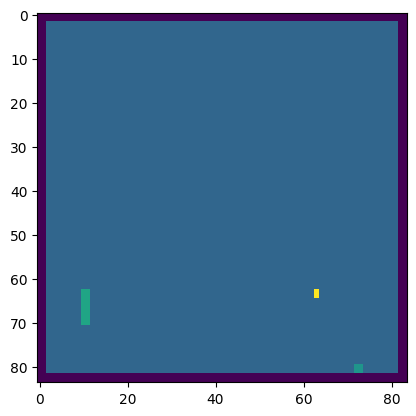

In [9]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
from ray.rllib.core.rl_module import RLModule
import pathlib
import torch
from ray.rllib.utils.numpy import convert_to_numpy, softmax
from ray.rllib.core.columns import Columns
best_checkpoint = "/tmp/tmp_n7lvhjk"#/tmp/tmpnj4amrtt"

# Create only the neural network (RLModule) from our checkpoint.
rl_module = RLModule.from_checkpoint(
    pathlib.Path(best_checkpoint) / "learner_group" / "learner" / "rl_module"
)["default_policy"]

import PIL.Image
env = custom_env_creator({})
obs, info = env.reset()
#env.render()

for _ in range(120):

    fwd_ins = {"obs": torch.Tensor([obs])}
    fwd_outputs = rl_module.forward_inference(fwd_ins)
    # this can be either deterministic or stochastic distribution
    #action_dist = action_dist_class.from_logits(
    #    fwd_outputs["action_dist_inputs"]
    #)
    logits = convert_to_numpy(fwd_outputs[Columns.ACTION_DIST_INPUTS])
    # Compute the next action from a batch (B=1) of observations.
    ##torch_obs_batch = torch.Tensor(np.array([obs]))
    #aforwInf = rl_module.forward_inference({"obs": torch_obs_batch})
    ##action_logits = rl_module.forward_inference({"obs": torch_obs_batch})[
    ##    "actions"
    ##]
    # The default RLModule used here produces action logits (from which
    # we'll have to sample an action or use the max-likelihood one).
    #action = torch.argmax(logits[0]).numpy()
    #print(softmax(logits[0]))
    action = np.random.choice(env.action_space.n, p=softmax(logits[0]))
    print(softmax(logits[0]))
    #action = dqn.compute_single_action(obs)
    #action = env.action_space.sample()
    print(logits)
    print(action)
    obs, reward, terminated, truncated, info = env.step(action)
    clear_output(wait=True)
    plt.imshow(obs)
    plt.show()

    if terminated:
        obs, info = env.reset()
env.close()


